In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import pandas as pd
from glob import glob
import pylab
import os
import seaborn as sns
from matplotlib.patches import Rectangle
import csv
import random
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import gc


det_class = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_detailed_class_info.csv'
boxes = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_labels.csv'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Niyati\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-b475b11d1f8f>", line 14, in <module>
    import tensorflow as tf
  File "C:\Users\Niyati\Anaconda3\lib\site-packages\tensorflow\__init__.py", line 98, in <module>
    from tensorflow_core import *
  File "C:\Users\Niyati\Anaconda3\lib\site-packages\tensorflow_core\__init__.py", line 40, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 959, in _find_and_load_unlocked
  File "C:\Users\Niyati\Anaconda3\lib\site-packages\tensorflow\__init__.py", line 50, in __getattr__
    module = self._load()
  File "C:\Users\Niyati\Anaconda3\lib\site-packages\tensorflow\__init__.py", line 44, in _load
    module = _importlib.import_module(sel

TypeError: expected bytes, Descriptor found

30227 class infos loaded
26684 patient cases


,patientId,class
24093,d8a4d7fd-37b4-4d9a-aed8-2648ebff3c0c,No Lung Opacity / Not Normal
9641,6922deb4-3824-43cb-b636-7ca579e4d64f,No Lung Opacity / Not Normal
16626,a0a46571-f455-4680-89c2-c1aa97f55f6f,No Lung Opacity / Not Normal


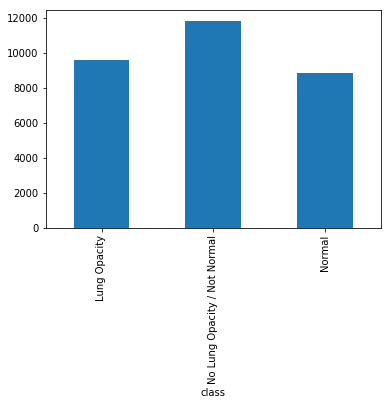

In [3]:
det_class_df = pd.read_csv(det_class)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)


In [4]:
boxes_df = pd.read_csv(boxes)
print(boxes_df.shape[0], 'boxes')
print(boxes_df['patientId'].value_counts().shape[0], 'patient cases')
boxes_df.sample(10)

30227 boxes
26684 patient cases


,patientId,x,y,width,height,Target
3816,3ae1c3de-e2a7-44f5-b794-b1ef71640d0f,183.0,504.0,223.0,149.0,1
6183,4cd5215c-acf1-4ee9-8790-b9500b3ef404,NaN,NaN,NaN,NaN,0
16877,a288ccb7-b58d-4411-a5da-6dce74957e74,33.0,304.0,207.0,342.0,1
24111,d8cf8e37-9ba7-47ea-9e78-0c635e550583,NaN,NaN,NaN,NaN,0
6306,4de82994-1662-4fd2-ae76-e70667dab381,189.0,287.0,392.0,298.0,1
24819,deda4033-e93f-42c0-8b7a-833ce322505b,NaN,NaN,NaN,NaN,0
17417,a6905106-5479-4725-b81f-532376d24222,675.0,451.0,300.0,363.0,1
26354,eb3aff4d-df68-4d3e-a858-e8a28df962ca,NaN,NaN,NaN,NaN,0
1212,10223464-9ce5-4445-ba26-cd5a01ed5d4f,NaN,NaN,NaN,NaN,0
3992,3c002750-bb77-48be-ab63-2440f9283d53,NaN,NaN,NaN,NaN,0


In [5]:
combined_df = pd.merge(boxes_df, det_class_df, how='inner', on='patientId')
print(combined_df.shape[0], 'combined cases')

37629 combined cases


In [6]:
combined_df = pd.concat([boxes_df, 
                        det_class_df.drop('patientId',1)], 1)
print(combined_df.shape[0], 'combined cases')
combined_df.sample(10)
forSVM_df = combined_df


30227 combined cases


In [7]:
final = combined_df.dropna()
print(final.shape[0], 'combined cases')
final.sample(10)

9555 combined cases


,patientId,x,y,width,height,Target,class
1514,1693a790-88c8-46fa-9ce7-3b0c5834ba90,215.0,273.0,131.0,150.0,1,Lung Opacity
1797,18dea804-4283-4c5c-94ea-47c42bbb619e,83.0,163.0,326.0,640.0,1,Lung Opacity
20420,baf8fe18-a7ca-4e9c-b3dc-5c80d474545b,624.0,368.0,262.0,222.0,1,Lung Opacity
19222,b3332044-d191-4d1d-8cca-b11c30c79fa8,229.0,250.0,233.0,385.0,1,Lung Opacity
29867,27feebaa-f4dc-4c68-9348-f0ff35134e43,210.0,590.0,252.0,211.0,1,Lung Opacity
16239,9d7688a1-8de2-414f-ab31-acb03992c952,531.0,393.0,272.0,317.0,1,Lung Opacity
15420,96c14a9c-2346-4e84-88c9-ad30bd422de8,280.0,293.0,129.0,299.0,1,Lung Opacity
30074,2f200e3f-8e4c-4675-948c-8226cd65163a,639.0,337.0,201.0,352.0,1,Lung Opacity
18715,afe8e940-8718-4fbe-b852-fd462a7c3274,359.0,431.0,109.0,156.0,1,Lung Opacity
5183,44da3869-4815-4f7c-9350-a396d9961443,282.0,383.0,156.0,197.0,1,Lung Opacity


<Figure size 432x288 with 0 Axes>

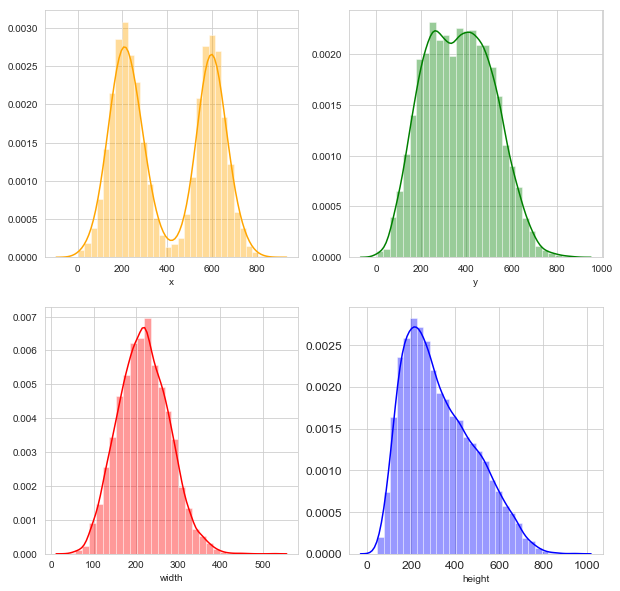

In [8]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(10,10))
sns.distplot(final['x'],kde=True,bins=30, color="orange", ax=ax[0,0])
sns.distplot(final['y'],kde=True,bins=30, color="green", ax=ax[0,1])
sns.distplot(final['width'],kde=True,bins=30, color="red", ax=ax[1,0])
sns.distplot(final['height'],kde=True,bins=30, color="blue", ax=ax[1,1])

locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

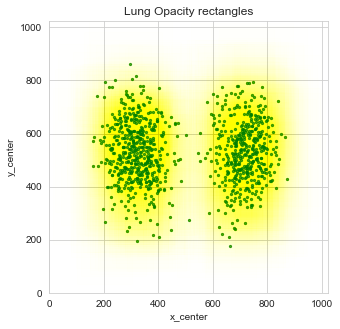

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
final1 = final.sample(1000)
final1['x_center'] = final1['x'] + final1['width'] / 2
final1['y_center'] = final1['y'] + final1['height'] / 2
plt.title("Lung Opacity rectangles")
final1.plot.scatter(x='x_center', y='y_center', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.7, marker=".", color="green")
for i, sample in final1.iterrows():
    ax.add_patch(Rectangle(xy=(sample['x'], sample['y']),
                width=sample['width'],height=sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [11]:
final.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555


In [12]:
box_df = combined_df.groupby('patientId').size().reset_index(name='boxes')
combined_df = pd.merge(combined_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


In [13]:
box1_df = final.groupby('patientId').size().reset_index(name='boxes1')
final = pd.merge(final, box1_df, on='patientId')
box1_df.groupby('boxes1').size().reset_index(name='patients')

,boxes1,patients
0,1,2614
1,2,3266
2,3,119
3,4,13


In [14]:
images = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_detailed_class_info.csv'
boxes = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_labels.csv'

boxes = pd.read_csv('C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_labels.csv')
print(boxes.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [15]:
print(boxes.iloc[8])

patientId    00704310-78a8-4b38-8475-49f4573b2dbb
x                                             323
y                                             577
width                                         160
height                                        104
Target                                          1
Name: 8, dtype: object


In [16]:
patientId = boxes['patientId'][8]
print(patientId)
dicom_file = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_images/%s.dcm' % patientId
myDICOM = pydicom.read_file(dicom_file)

00704310-78a8-4b38-8475-49f4573b2dbb


In [17]:
image_pixel = myDICOM.pixel_array
print(type(image_pixel))
print(image_pixel.shape)

<class 'numpy.ndarray'>
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

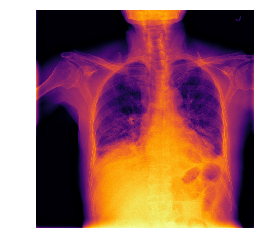

In [18]:
pylab.imshow(image_pixel, cmap=pylab.cm.inferno)
pylab.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

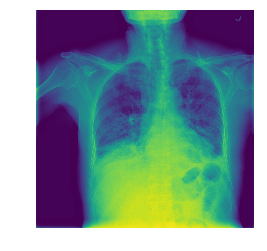

In [19]:
pylab.imshow(image_pixel, cmap=pylab.cm.viridis)
pylab.axis('off')

0004cfab-14fd-4e49-80ba-63a80b6bddd6


(-0.5, 1023.5, 1023.5, -0.5)

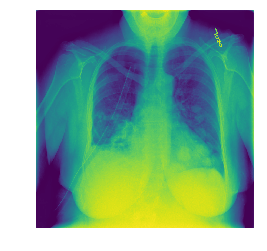

In [20]:
patientId = boxes['patientId'][0]
print(patientId)
dicom_file = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_images/%s.dcm' % patientId
myDICOM = pydicom.read_file(dicom_file)
image_pixel = myDICOM.pixel_array
pylab.imshow(image_pixel, cmap=pylab.cm.viridis)
pylab.axis('off')

In [22]:
def parse_data(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows(): 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [23]:
parsed = parse_data(boxes)

In [24]:
def constructBoxes(image):
    d = pydicom.read_file(image['dicom'])
    pixels = d.pixel_array
    #Convert from 3d for rgb pixels
    pixels = np.stack([pixels] * 3, axis=2)

    for box in image['boxes']:
        rgb = [0,255,0]
        pixels = overlay_box(pixels=pixels, box=box, rgb=rgb, stroke=8)
    pylab.imshow(pixels, cmap=pylab.cm.viridis)
    pylab.axis('off')

def overlay_box(pixels, box, rgb, stroke=8):
    #get integers coordinates
    box = [int(b) for b in box]
    
    #get x,y coordinates
    y1, x1, height, width = box
    y2 = y1 + height 
    x2 = x1 + width

    pixels[y1:y1 + stroke, x1:x2] = rgb
    pixels[y2:y2 + stroke, x1:x2] = rgb
    pixels[y1:y2, x1:x1 + stroke] = rgb
    pixels[y1:y2, x2:x2 + stroke] = rgb

    return pixels

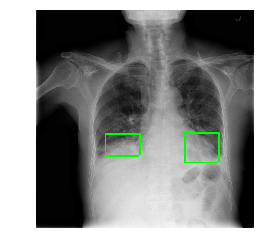

In [25]:
constructBoxes(parsed['00704310-78a8-4b38-8475-49f4573b2dbb'])

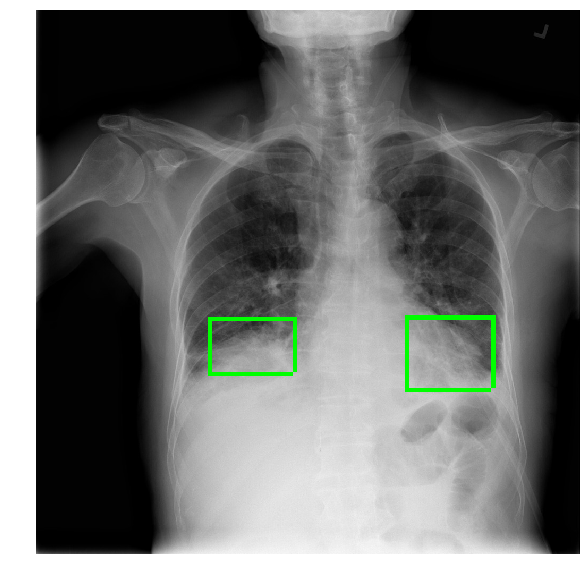

In [26]:
fig=plt.figure(figsize=(20, 10))
constructBoxes(parsed['00704310-78a8-4b38-8475-49f4573b2dbb'])
plt.show()

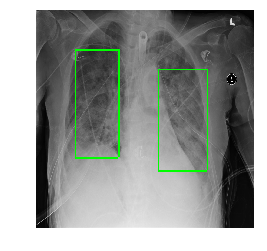

In [27]:
constructBoxes(parsed['00f08de1-517e-4652-a04f-d1dc9ee48593'])

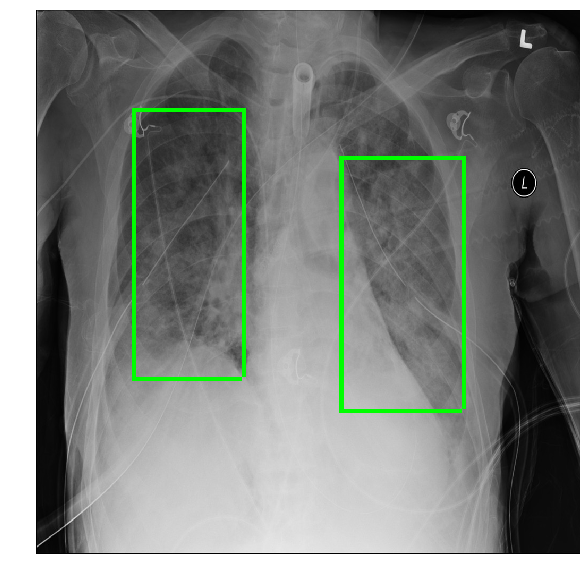

In [28]:
fig=plt.figure(figsize=(20, 10))
constructBoxes(parsed['00f08de1-517e-4652-a04f-d1dc9ee48593'])
plt.show()

In [39]:
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import csv

In [40]:
pneumonia_locations = {}
# load table
with open(os.path.join('C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [41]:
folder = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_images'
filenames = os.listdir(folder)
print(len(filenames))
# split into train and test filenames
test = int(len(filenames) * 0.2)
print(test)
train = filenames[test:]
test = filenames[:test]
print('train', len(train))
print('test', len(test))

26684
5336
train 21348
test 5336


In [42]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=320, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
    
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
            
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [43]:
BATCH_SIZE = 16
IMAGE_SIZE = 320

In [45]:
def downSample(channels, inputs):
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def resNet(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def myRESNET(input_size, channels, blocks=2, depth=3):
    #Input layer
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    #Residual layer
    for d in range(depth):
        channels = channels * 2
        x = downSample(channels, x)
        for b in range(blocks):
            x = resNet(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(256, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2DTranspose(128, (8,8), (4,4), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(64,1, padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
    outputs = keras.layers.UpSampling2D(2**(depth-2))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [59]:
# create network and compiler
model = myRESNET(input_size=320, channels=32, blocks=2, depth=3)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# create train and validation generators
train_gen = generator(folder, train, pneumonia_locations, batch_size=16, image_size=320, shuffle=True, augment=True, predict=False)
test_gen = generator(folder, test, pneumonia_locations, batch_size=16, image_size=320, shuffle=False, predict=False)

print(model.summary())
                                                

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 320, 320, 32) 288         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 320, 320, 64) 2048        conv2d_78[0][0]                  
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 320, 320, 64) 256         conv2d_79[0][0]                  
____________________________________________________________________________________________

In [61]:
myRESNET = model.fit_generator(train_gen, validation_data=test_gen, epochs=1, shuffle=True)

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


   1/1334 [..............................] - ETA: 53:34:22 - loss: 0.7132 - accuracy: 0.5962

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

   2/1334 [..............................] - ETA: 35:16:11 - loss: 0.5742 - accuracy: 0.7906

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

   3/1334 [..............................] - ETA: 29:05:32 - loss: 0.5044 - accuracy: 0.8406

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

   4/1334 [..............................] - ETA: 26:04:23 - loss: 0.4462 - accuracy: 0.8750

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


   5/1334 [..............................] - ETA: 24:18:45 - loss: 0.4039 - accuracy: 0.8979

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


   6/1334 [..............................] - ETA: 22:59:01 - loss: 0.3764 - accuracy: 0.9105

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

   7/1334 [..............................] - ETA: 22:02:16 - loss: 0.3568 - accuracy: 0.9182

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

   8/1334 [..............................] - ETA: 21:21:15 - loss: 0.3341 - accuracy: 0.9277

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


   9/1334 [..............................] - ETA: 20:48:45 - loss: 0.3206 - accuracy: 0.9320

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

  10/1334 [..............................] - ETA: 20:22:22 - loss: 0.3043 - accuracy: 0.9380

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

  11/1334 [..............................] - ETA: 20:01:10 - loss: 0.2966 - accuracy: 0.9395

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  12/1334 [..............................] - ETA: 19:43:39 - loss: 0.2829 - accuracy: 0.9442

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

  13/1334 [..............................] - ETA: 19:27:51 - loss: 0.2751 - accuracy: 0.9461

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  14/1334 [..............................] - ETA: 19:13:52 - loss: 0.2708 - accuracy: 0.9465

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

  15/1334 [..............................] - ETA: 19:01:51 - loss: 0.2648 - accuracy: 0.9477

C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\Niyati\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down

KeyboardInterrupt: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import pandas as pd

forSVM_df.shape
forSVM_df.sample(20)
forSVMFinal_df = forSVM_df.drop('class', axis = 1).copy()
forSVMFinal_df.sample(20)

ModuleNotFoundError: No module named 'numpy.core._ufunc_config'

In [5]:
detailed_class_info = pd.read_csv('C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_labels.csv')

df = pd.merge(left = detailed_class_info, right = train_labels, how = 'left', on = 'patientId')

del detailed_class_info, train_labels
gc.collect()

df = df.drop_duplicates()
df_meta = df.drop('class', axis = 1).copy()
df_meta.sample(20)

NameError: name 'pd' is not defined

In [74]:
df_meta.shape

(30227, 27)

In [3]:
def dicomEachPatient(pid):
    return pydicom.read_file('C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_images/%s.dcm' % pid)

def getMetaData(pid, columns):
    dicom = dicomEachPatient(pid)
    wantedColumn = getattr(dicom, columns)
    return wantedColumn

In [4]:
columns = ['PatientSex', 'PatientAge', 'ViewPosition']
for i in columns:
    forSVMFinal_df[i] = forSVMFinal_df['patientId'].apply(lambda l: getMetaData(l, i))
forSVMFinal_df['PatientAge'] = forSVMFinal_df['PatientAge'].apply(pd.to_numeric, errors='coerce')
forSVMFinal_df['PatientAge'] = forSVMFinal_df['PatientAge'].apply(lambda l: l if l<120 else np.nan)


NameError: name 'forSVMFinal_df' is not defined

In [77]:
forSVMFinal_df.head()

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,F,32.0,AP


In [78]:
svmDuplicate_df = forSVMFinal_df

In [79]:
svmDuplicate_df.sample(20)

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
4432,3edd91fd-fa2d-472d-8c4f-14b57ff1bf4c,NaN,NaN,NaN,NaN,0,M,17.0,PA
10763,719c6eac-44d9-44ae-a090-29e17f9349bf,586.0,361.0,289.0,188.0,1,F,30.0,PA
7830,5a4ba729-d074-4991-ba3d-9247f17db955,NaN,NaN,NaN,NaN,0,F,24.0,AP
27488,f4113fee-b7a0-472c-8f68-24e999fbf73a,228.0,375.0,185.0,294.0,1,F,66.0,PA
24228,d9b01ff8-9c05-4d34-af56-689f0fbfef5e,NaN,NaN,NaN,NaN,0,F,48.0,PA
14308,8dc8e54b-5b05-4dac-80b9-fa48878621e2,281.0,163.0,201.0,253.0,1,M,76.0,AP
12067,7bf0f0cb-90ff-4e61-ab52-e05053689108,NaN,NaN,NaN,NaN,0,F,39.0,AP
18602,af0a996a-d4a0-44c7-b316-72176ea9838b,240.0,249.0,217.0,270.0,1,F,55.0,AP
20480,bb6164ee-9b30-4b94-85ca-5f9d94b2ce4a,270.0,182.0,239.0,508.0,1,M,49.0,AP
4418,3ec0d348-9d0a-4f8a-8dfa-45e576ef62cc,NaN,NaN,NaN,NaN,0,F,65.0,PA


In [80]:
svmDuplicate_df['PatientSex'] = svmDuplicate_df['PatientSex'].map({'F': 0, 'M': 1}) 
svmDuplicate_df['ViewPosition'] = svmDuplicate_df['ViewPosition'].map({'PA': 0, 'AP': 1}) 

In [83]:
forSVMFinal_df.head()

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0,51.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,0,48.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,19.0,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,28.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0,32.0,1


In [86]:
from sklearn.svm import SVC
sklearn.model_selection.train_test_split(forSVMFinal_df["PatientSex"],forSVMFinal_df["PatientAge"],forSVMFinal_df["ViewPosition"])

NameError: name 'sklearn' is not defined

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

In [85]:
forSVMFinal_df["PatientSex"]

0        0
1        0
2        1
3        1
4        0
5        0
6        1
7        1
8        1
9        1
10       0
11       1
12       0
13       1
14       0
15       0
16       0
17       0
18       1
19       1
20       1
21       1
22       0
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
30197    0
30198    1
30199    1
30200    1
30201    1
30202    0
30203    0
30204    0
30205    0
30206    1
30207    0
30208    0
30209    0
30210    0
30211    0
30212    0
30213    1
30214    1
30215    1
30216    0
30217    1
30218    0
30219    0
30220    0
30221    1
30222    1
30223    0
30224    1
30225    0
30226    0
Name: PatientSex, Length: 30227, dtype: int64

In [1]:
forSVMFinal_df.to_csv (r'C:\Users\Niyati\Desktop\Northeastern\FAI\project', index = False, header=True)

NameError: name 'forSVMFinal_df' is not defined